From the features selected from AIT590_FeatureSelection. We have generted models.
1. Subset the data for each city
2. Generate user-Rating Matrix
3. Apply K-Means clustering
4. Apply Extra Tree Classifier to exatrct feature important

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import SpectralClustering, KMeans
import networkx as nx
from matplotlib import pyplot as plt
from scipy.sparse.linalg import svds
from kneed import KneeLocator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import collections
from statistics import mean
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score

In [16]:
data = pd.read_csv('FinalFeatures1.csv')

##### Understanding data

In [17]:
data.columns

Index(['Unnamed: 0', 'review', 'business', 'aioli', 'albacore', 'american',
       'angus', 'apple', 'argula', 'asiago',
       ...
       'vino', 'waffle', 'whipped', 'white', 'wine', 'yummy', 'stars', 'city',
       'latitude', 'longitude'],
      dtype='object', length=265)

In [18]:
data.shape

(500, 265)

In [19]:
data = data.drop('Unnamed: 0',1)

In [20]:
userdata = pd.read_csv('AIT590-data.csv')
#userdata = pd.read_csv("C:/Users/varal/Downloads/AIT590-data.csv")

In [21]:
userdata.columns

Index(['business_id', 'name', 'city', 'postal_code', 'latitude', 'longitude',
       'Restaurant Rating', 'review_count', 'user_id', 'review_id',
       'User-RestaurantRating', 'text', 'date', 'user-reviewCount'],
      dtype='object')

In [22]:
userdata.shape

(30199, 14)

In [23]:
# Dropping the rows where user id is unknown
userdata = userdata[userdata['user_id'] != '#NAME?']

In [24]:
# On whole we have 966 users, where max number ratings a user has given is 150 and min is 21
len(set(userdata['user_id']))

966

In [25]:
# Droping Rows where Restaurant (business id is unknown)
# Finally we will have 494 restaurants
data = data[data['business'] != '#NAME?']

In [26]:
userdata = userdata[userdata['business_id'] != '#NAME?']

In [27]:
data['city'].value_counts()

Cleveland     100
Charlotte     100
Pittsburgh    100
Las Vegas      99
Phoenix        95
Name: city, dtype: int64

In [28]:
# Sub setting the data for each city
dataCharlotte = userdata[userdata['city'] == 'Charlotte']
dataPittsburgh = userdata[userdata['city'] == 'Pittsburgh']
dataCleveland = userdata[userdata['city'] == 'Cleveland']
dataVegas = userdata[userdata['city'] == 'Las Vegas']
dataPhoenix = userdata[userdata['city'] == 'Phoenix']

In [29]:
len(set(userdata['business_id']))
dataCharlotte.columns

Index(['business_id', 'name', 'city', 'postal_code', 'latitude', 'longitude',
       'Restaurant Rating', 'review_count', 'user_id', 'review_id',
       'User-RestaurantRating', 'text', 'date', 'user-reviewCount'],
      dtype='object')

In [30]:
len(set(userdata['user_id']))

966

In [31]:
userdata.shape

(29493, 14)

In [32]:
'''spectral clustering
# degree matrix
    #D = np.diag(np.sum(np.array(similarity), axis=1))
    # laplacian matrix
    #L = D - similarity
    # e is eigen values, v is eigen vectors
    #e, v = np.linalg.eig(L)
    #v = v[:,np.argsort(e)]
    #e = e[np.argsort(e)]
    #e1 = list(e)
    #largest_gap = np.argmax(np.diff(e1))
    #clusters = largest_gap+1
    '''

'spectral clustering\n# degree matrix\n    #D = np.diag(np.sum(np.array(similarity), axis=1))\n    # laplacian matrix\n    #L = D - similarity\n    # e is eigen values, v is eigen vectors\n    #e, v = np.linalg.eig(L)\n    #v = v[:,np.argsort(e)]\n    #e = e[np.argsort(e)]\n    #e1 = list(e)\n    #largest_gap = np.argmax(np.diff(e1))\n    #clusters = largest_gap+1\n    '

In [45]:
# The below method generates user-ratings matrix, performs elbow method and to identify the appropriate number of clusters
# Apply K-Means clustering and label the data
def userRestaurantMatrix(data):
    matrix = pd.pivot_table(data,values='User-RestaurantRating',index=['user_id'], columns=['business_id'],fill_value = 0)
    new_df = pd.DataFrame(matrix.to_records())
    ID = list(new_df.columns)
    ID.remove('user_id')
    # SVD - Matrix Factorization
    user_ratings_mean = np.mean(matrix, axis = 1)
    R_demeaned = matrix - user_ratings_mean.values.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k = 50)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)
    ###
    new_df = pd.DataFrame(all_user_predicted_ratings, columns = list(new_df.columns)[1:])
    #print(new_df.shape)
    # Pairwise similarity
    similarity = cosine_similarity(new_df.T)
    # K-Means
    #print(np.shape(similarity))
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(similarity)
        sse.append(kmeans.inertia_)
    # Kneed method is used to identify the best number of clusters
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    # We are using elbow method to identify the best number of clusters
    cluster = kl.elbow
    # Clustering our dataset
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(similarity[:])
    colors = kmeans.labels_
    print(len(colors))
    return similarity, sse, list(colors), cluster, ID

In [54]:
#Creating user Restaurant Matrix, generating pairwise cosine similarity matrix to identify how similar are these restaurants
similarityCharlotte, sseCharlotte, colorCharlotte,c1, IDCharlotte = userRestaurantMatrix(dataCharlotte) 
similarityPittsburgh, ssePittsburgh, colorPittsburgh, c2, IDPittsburgh = userRestaurantMatrix(dataPittsburgh)
similarityCleveland, sseCleveland, colorCleveland, c3, IDCleveland = userRestaurantMatrix(dataCleveland)
similarityVegas, sseVegas, colorVegas, c4, IDVegas = userRestaurantMatrix(dataVegas)
similarityPhoenix, ssePhoenix, colorPhoenix, c5, IDPhoenix = userRestaurantMatrix(dataPhoenix)

100
100
100
99
95


In [55]:
similarityCharlotte

array([[1.        , 0.38947161, 0.38498418, ..., 0.51578331, 0.40149393,
        0.33478741],
       [0.38947161, 1.        , 0.17631195, ..., 0.33766623, 0.35196152,
        0.11804673],
       [0.38498418, 0.17631195, 1.        , ..., 0.24771833, 0.28399848,
        0.1384133 ],
       ...,
       [0.51578331, 0.33766623, 0.24771833, ..., 1.        , 0.39463587,
        0.37805851],
       [0.40149393, 0.35196152, 0.28399848, ..., 0.39463587, 1.        ,
        0.10476029],
       [0.33478741, 0.11804673, 0.1384133 , ..., 0.37805851, 0.10476029,
        1.        ]])

In [56]:
print(' '+str(c1)+' '+str(c2)+' '+str(c3)+' '+str(c4)+' '+str(c5))

 4 4 3 3 4


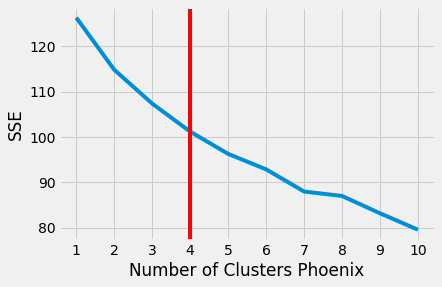

In [68]:
# plot for sse, to identify the appropriate number of clusters
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), ssePhoenix)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters Phoenix")
plt.ylabel("SSE")
plt.axvline(c5,color = 'r')
plt.show()

In [114]:
# add label to the data, extract features for each city. We used cross_val_score to find accuracy 
def featureImportance(data,city,c,business_ID):
    data = data[data['city'] == city]
    #data = data.dropna()
    df = pd.DataFrame()
    df['business'] = business_ID
    df['cluster'] = c
    final_data = pd.merge(data, df.rename(columns={'business':'business'}), on='business',  how='left')
    final_data = final_data.reset_index()
    final_data = final_data.drop('business',1)
    Y = final_data['cluster'] # target column
    X = final_data.drop(columns = ['cluster','review','city','stars','index','latitude','longitude'])  #independent columns
    d = pd.DataFrame()
    d['latitude'] = data['latitude']
    d['longitude'] = data['longitude']
    d['cluster'] = c
    d['city'] = city
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    model = ExtraTreesClassifier()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # F1 score
    #f1 = accuracy_score(y_test, y_pred)
    f1 = cross_val_score(model, X, Y, cv=5)
    f1 = mean(f1)
    # feature importance
    features = model.feature_importances_
    # list of column names from original data
    cols = X.columns
    # feature importances from random forest fit rf
    # form dictionary of feature ranks and features
    features_dict = dict(zip(np.argsort(features),cols))
    features_dict = sorted(features_dict.items())[:20]
    # Extracting features from list
    feature = []
    for item in features_dict:
        feature.append(item[1])
    # the dictionary key are the importance rank; the values are the feature name
    return f1,feature,d

In [115]:
f1,x1,d1 = featureImportance(data,'Pittsburgh',colorPittsburgh,IDPittsburgh)
f2, x2,d2 = featureImportance(data,'Las Vegas',colorVegas,IDVegas)
f3,x3,d3 = featureImportance(data,'Charlotte',colorCharlotte,IDCharlotte)
f4,x4,d4 = featureImportance(data,'Phoenix',colorPhoenix,IDPhoenix)
f5,x5,d5 = featureImportance(data,'Cleveland',colorCleveland,IDCleveland)

In [116]:
print(' '+str(f1)+' '+str(f2)+' '+str(f3)+' '+str(f4)+' '+str(f5))

 0.36 0.7784210526315789 0.43 0.47368421052631576 0.6


In [117]:
features = [x1,x2,x3,x4,x5]

In [118]:
data1 = pd.DataFrame()
data1 = data1.append(d1)
data1 = data1.append([d2,d3,d4,d5])